In [ ]:
'''
本页内容：
下载IMDB数据集
探索数据
    将整数转换回单词
准备数据
构建模型
    隐层单元
    损失函数与优化器
创建一个验证集
训练模型
评估模型
创建一个准确率（accuracy）和损失值（loss）随时间变化的图表


使用评论文本将影评分为积极或消极类型，这是一个二分类问题

我们将使用来源于网络电影数据库的IMDB数据集，其中包含50000条影评文本，
从该数据集切割出25000条评论用作训练，另外25000条用作测试，训练集与测试集是平衡的，意味着他们包含相等数量的积极与消极评论


IMDB 数据集已经打包在 Tensorflow 中。
该数据集已经经过预处理，评论（单词序列）已经被转换为整数序列，其中每个整数表示字典中的特定单词。

'''

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
print(tf.__version__)

2.12.0


In [3]:
# 下载的IMDB数据集
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# 参数 num_words=10000 保留了训练数据中最常出现的 10,000 个单词。
# 为了保持数据规模的可管理性，低频词将被丢弃

17464789/17464789 [==============================] - 4s 0us/step


In [4]:
# SECTION: 探索数据
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
# 评论文本将被转化为整数值，其中每个整数代表词典中的一个单词
print("首条评论：", train_data[0])
# 电影评论可能具有不同的长度，但是神经网络的输入必须是统一的长度，因此还需解决该问题
print(len(train_data[0]), len(train_data[1]))

Training entries: 25000, labels: 25000
首条评论： [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218 189


In [7]:
# SECTION 将整数转换会单词
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 #unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [9]:
# SECTION 准备数据
'''
影评-- 即整数数组必须在输入神经网络之前转换为张量，这种转换可以通过两种方式来完成

- 将数组转换为表示单词出现与否的由0和1组成的向量，类似于one-hot编码。例如
例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。

然后将其作为网络的首层——一个可以处理浮点型向量数据的稠密层，不过这种方法需要大量内存，
需要一个大小为num_words*num_reviews的矩阵

或者我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为max_length * num_reciews的整形张量。

我们可以使用能够处理此形状数据的嵌入层作为网络的第一层


'''

# TODO: 由于电影评论长度必须相同，我们将使用pad_sequences函数来使长度标准化

train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=word_index["<PAD>"],padding='post',maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=word_index["<PAD>"],padding='post',maxlen=256)

print("查看样本长度：", len(train_data[0]),len(test_data[1]))

print("并检查首条评论：", decode_review(train_data[0]))

查看样本长度： 256 256
并检查首条评论： <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and 

In [10]:
# SECTION: 构建模型
'''
神经网络有堆叠的层来构建，这需要从啷个主要方面来进行体系结构决策：
- 模型里有多少层、
- 每个层有多少个隐层单元（hidden units）

- 第一层是嵌入层（EMBEDDING）层，该层采用整数编码的词汇表，并查找每个词汇索引的嵌入向量（embedding vector）.这些向量是通过模型训练学习到的，

- 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。

- 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。

- 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。


z在此样本中，输入数据包含一个单词索引的数组，要预测的标签为0或1，


'''

# TODO: 输入形状是用于电影评论的词汇数目（10000词）

vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16)) # 嵌入层
model.add(keras.layers.GlobalAvgPool1D()) # 池化层
model.add(keras.layers.Dense(16, activation='relu')) #全连接池
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [11]:
''' SECTION：隐层单元
上述模型在输入输出之间有两个中间层或隐藏层。输出（单元，结点或神经元）的数量即为层表示空间的维度
换句话说就是学习内部表示时网络所允许的自由度

如果模型具有更多的隐层单元（更高维度的表示空间）和/或更多层,则可以学习到更复杂的表示

'''

''' SECTION: 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题，且模型输出概率值（一个使用sigmoid激活函数的单一单元层），我们将使用binary_crossentropy损失函数

binary_crossentropy 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。
'''

# 配置模型来使用优化器和损失函数
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# SECTION: 创建一个验证集
'''
在训练时，我们想要检查模型在未见过的数据上的准确率，通过从原始训练数据中分离10000个样本来创建一个验证集
（为什么现在不使用测试集？ 我们的目标是只使用训练数据来开发和调整模型，然后只使用一次测试数据来评估模型）


 验证集可以用在训练的过程中，一般在训练时，几个epoch结束后跑一次验证集看看效果。(验证得太频繁会影响训练速度)这样做的第一个好处是，可以及时发现模型或者参数的问题，比如模型在验证集上发散啦、出现很奇怪的结果啦(如无穷大)、mAP不增长或者增长很慢啦等等情况，这时可以及时终止训练，重新调参或者调整模型，而不需要等到训练结束。另外一个好处是验证模型的泛化能力，如果在验证集上的效果比训练集上差很多，就该考虑模型是否过拟合了。同时，还可以通过验证集对比不同的模型。在一般的神经网络中， 我们用验证数据集去寻找最优的网络深度（number of hidden layers)，或者决定反向传播算法的停止点或者在神经网络中选择隐藏层神经元的数量；

'''

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# SECTION: 训练模型
'''
以512个样本的mini-batch大小迭代40个epoch来训练模型。
这是指对x_train和y_train张量中所有样本的40次迭代

在训练过程中，检测来自验证集的10000个样本的损失值和准确率

'''
history = model.fit(partial_x_train, partial_y_train, epochs=40, batch_size=512, validation_data=(x_val, y_val), verbose=1)


Epoch 1/40
30/30 [==============================] - 1s 13ms/step - loss: 0.6922 - accuracy: 0.5723 - val_loss: 0.6906 - val_accuracy: 0.7120
Epoch 2/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.7489 - val_loss: 0.6839 - val_accuracy: 0.7489
Epoch 3/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6768 - accuracy: 0.7481 - val_loss: 0.6701 - val_accuracy: 0.7588
Epoch 4/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6571 - accuracy: 0.7735 - val_loss: 0.6470 - val_accuracy: 0.7655
Epoch 5/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6270 - accuracy: 0.7876 - val_loss: 0.6140 - val_accuracy: 0.7635
Epoch 6/40
30/30 [==============================] - 0s 10ms/step - loss: 0.5870 - accuracy: 0.8033 - val_loss: 0.5740 - val_accuracy: 0.8030
Epoch 7/40
30/30 [==============================] - 0s 10ms/step - loss: 0.5408 - accuracy: 0.8282 - val_loss: 0.5308 - val_accuracy: 0.8175
Epoch 8/40
30

In [12]:
# SECTION" 评估模型
results = model.evaluate(test_data, test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3280 - accuracy: 0.8739 - 522ms/epoch - 668us/step
[0.32802921533584595, 0.8739200234413147]


In [13]:
# SECTION: 创建一个准确率和损失值随时间变化的图表
# model.fit()返回一个history对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件

history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

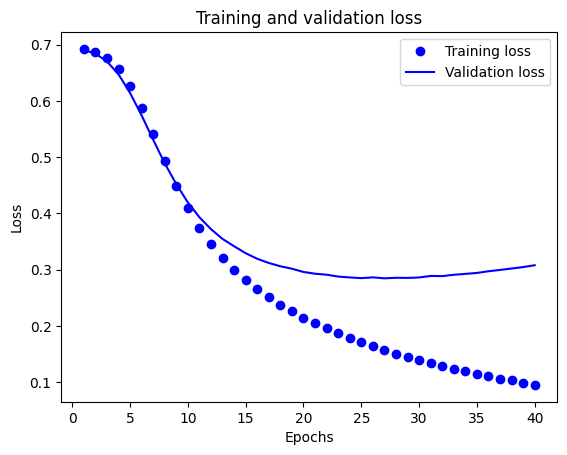

In [14]:
'''
有四个条目，在训练和验证期间，每个条目对应一个监控指标，我们可以使用这些条目来绘制训练与验证
过程的损失值与准确率，以便进行比较

'''
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"代表蓝点， “b”代表蓝色实线
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() # plt.legend()函数的作用是给图像加图例。

plt.show()




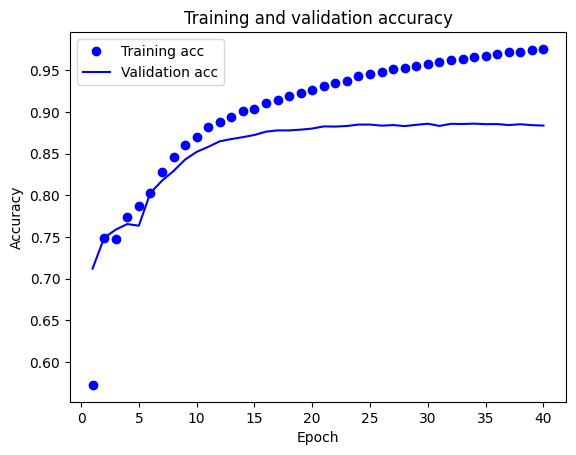

In [15]:
plt.clf() # 清除数字
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
'''
训练损失值随每个epoch下降而训练准确率随每个epoch上升，这在使用梯度下降优化时是可预期的

验证过程中的损失值与准确率却并非如此，他们似乎在20个epoch后达到顶峰。这是过拟合的一个实例：

模型在训练数据上的表现比在以前从为见过的变现要更好，
在此之后，模型过度优化并学习特定于训练数据的表示，而不能泛化到测试数据

对于这种特殊情况，我们可以通过在20个左右的epoch后停止训练来避免过拟合，

'''